# Analysis_Waterloo-Part5
In this section, we will analyze how the model works and create simplified linear models.

In [1]:
import scipy.io

import pandas as pd
import numpy as np
import statistics

import math
import seaborn as sns

import statistics

import re 
from scipy.stats import spearmanr

from platform import python_version
print(python_version())

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

from itertools import combinations_with_replacement, combinations

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter

from scipy.stats.stats import pearsonr, kendalltau, spearmanr

import pickle

3.7.4


In [2]:
final_model = pickle.load(open("final_model.sav", 'rb'))
data_all = pd.read_pickle("Part3_tmp")

In [3]:
categorical_subset = data_all[['content', 'motion', "Constant_bitrate"]]
mos = data_all["MOS"]
numerical_subset = data_all.copy()
numerical_subset = numerical_subset.drop (["MOS", 'content', 'motion', "Constant_bitrate"], axis = 1)
categorical_subset = pd.get_dummies(categorical_subset)
features = pd.concat([numerical_subset, categorical_subset], axis = 1)
features = pd.concat([features, data_all["MOS"]], axis = 1)
features = pd.concat([numerical_subset, categorical_subset], axis = 1)
targets = pd.DataFrame(data_all["MOS"])



def transmutation(mos):
    return math.log(mos/(100-mos))

for index, row in targets.iterrows():
     value = transmutation(row['MOS'])
     #print (value)
     targets.at[index, 'MOS'] = value
    
#X, X_test, train_labels, test_labels = train_test_split(features, targets,test_size = 0.3,random_state = 42)

import random

index_test =[]
index_val= []
for i in range(45):
    #random.seed(42) 
    #print (10*i, 9 + 10*i)
    a = random.randint(10*i, 9 + 10*i)
    index_test.append (a)
    #random.seed(24) 
    while (a != 0):
        b = random.randint(10*i, 9 + 10*i)
        if (a!=b):
            a = 0
            index_val.append (b)

#Stratified Sample for Regression
k=10
n = 45#450/k
k_folds = np.zeros((k,n))
#Sorteb by MOS
sorted_features = pd.concat([features, targets], axis = 1)
sorted_features = sorted_features.sort_values(['MOS'])
sorted_features.set_index(np.arange(450) )

val = sorted_features.iloc [index_val]

targets = pd.DataFrame(sorted_features["MOS"])
sorted_features = sorted_features.drop (["MOS"], axis = 1)



X = sorted_features.drop(index_test)
X = X.drop(index_val)
X_test = sorted_features.iloc [index_test]
X_val = sorted_features.iloc [index_val]

train_labels = targets.drop(index_test)
train_labels = train_labels.drop(index_val)
test_labels = targets.iloc [index_test]
val_labels = targets.iloc [index_val]

columns_save = sorted_features.columns
X_with_cols = pd.DataFrame(X, columns = columns_save)

# Transform both training data and testing data
X = np.array(X)
X_test = np.array(X_test)
X_val = np.array(X_val)

# Sklearn wants the labels as one-dimensional vectors
y = np.array(train_labels).reshape((-1,))
y_test = np.array(test_labels).reshape((-1,))
y_val = np.array(val_labels).reshape((-1, ))

In [4]:
final_model.fit(X,y)

/home/ksant/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=7,
                          max_features='auto', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=11,
                          min_weight_fraction_leaf=0.0, n_estimators=80,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

## Interprete the Model
Machine learning is often [criticized as being a black-box](https://www.technologyreview.com/s/604087/the-dark-secret-at-the-heart-of-ai/): we put data in on one side and it gives us the answers on the other. While these answers are often extremely accurate, the model tells us nothing about how it actually made the predictions. This is true to some extent, but there are ways in which we can try and discover how a model "thinks" such as the [Locally Interpretable Model-agnostic Explainer (LIME)](https://arxiv.org/pdf/1602.04938.pdf). This attemps to explain model predictions by learning a linear regression around the prediction, which is an easily interpretable model!

We will explore several ways to interpret our model:

* Feature importances
* Locally Interpretable Model-agnostic Explainer (LIME)
* Examining a single decision tree in the ensemble.

# Feature Importances

One of the basic ways we can interpret an ensemble of decision trees is through what are known as the feature importances. These can be interpreted as the variables which are most predictive of the target. While the actual details of the feature importances are quite complex ([here is a Stack Overflow question on the subject](https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined), we can use the relative values to compare the features and determine which are most relevant to our problem. 

Extracting the feature importances from a trained ensemble of trees is quite easy in scikit-learn. We will store the feature importances in a dataframe to analyze and visualize them.

In [5]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(X_with_cols.columns), 
                                #'importance': model.feature_importances_})
                                'importance': final_model.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,Ratio on sequense quality layer max/2,0.442411
1,Average Resolution,0.180587
2,mean(seqPSNR),0.059600
3,averageWeightedBitrate,0.058122
4,average duration of stalling event,0.046581
5,Rebuffer percentage,0.031534
6,motion,0.030555
7,content,0.025268
8,st_events_max,0.015526
9,Average relative Bitrate Swithcing magnitude,0.014773


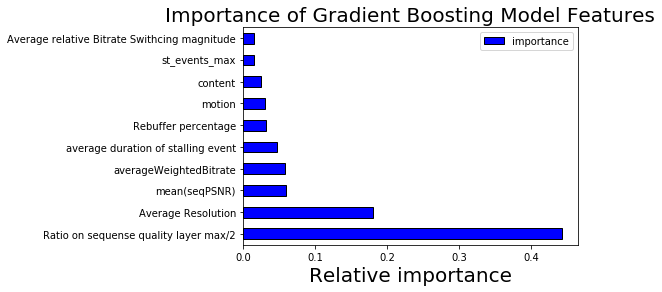

In [6]:
#plt.style.use('fivethirtyeight')

# Plot the 10 most important features in a horizontal bar chart
feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue');
plt.xlabel('Relative importance', size = 20); plt.ylabel('')
plt.title('Importance of Gradient Boosting Model Features', size = 20);

# Use Feature Importances for Feature Selection

Given that not every feature is important for finding the score, what would happen if we used a simpler model, such as a linear regression, with the subset of most important features from the random forest? The linear regression did outperform the baseline, but it did not perform well compared to the model complex models. Let's try using only the 10 most important features in the linear regression to see if performance is improved. We can also limit to these features and re-evaluate the random forest

In [7]:
# Extract the names of the most important features
most_important_features = feature_results['feature'][:10]

# Find the index that corresponds to each feature name
indices = [list(X_with_cols.columns).index(x) for x in most_important_features]

print(indices)

print(type(indices))

# Keep only the most important features
X_reduced = X[:, indices]
X_test_reduced = X_test[:, indices]

X_val_reduced = X_val[:, indices]

print('Most important training features shape: ', X_reduced.shape)
print('Most important testing  features shape: ', X_test_reduced.shape)

[20, 21, 3, 4, 2, 15, 25, 24, 5, 17]
<class 'list'>
Most important training features shape:  (360, 10)
Most important testing  features shape:  (45, 10)


In [81]:
def mae(y_true, y_val, y_pred, y_pred_val):    
    return np.mean(abs(y_true - y_pred)), np.mean(abs(y_val - y_pred_val))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    
    y_pred_val = model.predict(X_val)
    #model_mae = mae(y_test, model_pred)
    model_mae = mae(y_test, y_val, model_pred, y_pred_val)
    
    corr_test = spearmanr(test_labels, model_pred)
    corr_val = spearmanr(y_val, y_pred_val)
    
    print ("SRCC test", round(corr_test[0],4), corr_test[1])
    print ("SRCC validation", round(corr_val[0],4), corr_val[1])
    
    # Return the performance metric
    return model_mae, corr_test[0]

In [9]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr_mae, corr_lr = fit_and_evaluate(lr)

print('Linear Regression Performance: MAE test = %0.4f, MAE val = %0.4f' % lr_mae)

SRCC test 0.8378 7.134306581499497e-13
SRCC validation 0.8538 9.124246234134776e-14
Linear Regression Performance: MAE test = 0.2501, MAE val = 0.2958


## Reduced Linear model on 10 features desctiption 

In [10]:
print ("RLM10 =", lr.intercept_ , "+")
j=0
coefs_RLM10 = []
for i in indices:
    print (round(lr.coef_[j],4), "*",X_with_cols.columns[i]) 
    coefs_RLM10.append (lr.coef_[j])
    j+=1

RLM10 = -0.5312097713276689 +
-0.0659 * Ratio on sequense quality layer max/2
-0.1212 * Average Resolution
0.0528 * mean(seqPSNR)
0.0245 * averageWeightedBitrate
0.0 * average duration of stalling event
-0.0304 * Rebuffer percentage
0.2423 * motion
0.1849 * content
-0.0 * st_events_max
-0.0001 * Average relative Bitrate Swithcing magnitude


In [11]:
lr = LinearRegression()

# Fit on full set of features
lr.fit(X, y)
lr_full_pred = lr.predict(X_test)
lr_full_pred_val = lr.predict(X_val)

# Fit on reduced set of features
lr.fit(X_reduced, y)
lr_reduced_pred = lr.predict(X_test_reduced)
lr_reduced_pred_val = lr.predict(X_val_reduced)

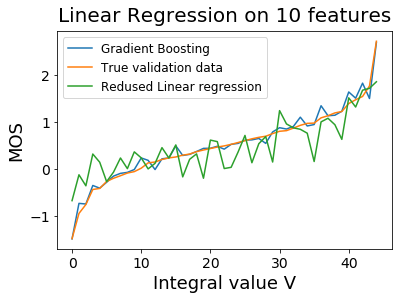

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

model_pred_val = final_model.predict(X_val)

plt.plot(model_pred_val, label = "Gradient Boosting")
plt.plot(y_val, label = "True validation data")

X_val_reduced = X_val[:, indices]

Redused_lin_reg = np.dot(X_val_reduced, lr.coef_) + lr.intercept_
plt.plot(Redused_lin_reg, label = "Redused Linear regression")

ax.set_title("Linear Regression on 10 features", fontsize=20, verticalalignment='bottom')

plt.legend(fontsize=12)
ax.set_xlabel("Integral value V", fontsize=18)
ax.set_ylabel("MOS", fontsize=18)

ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

# Lasso Linear Regression 
Let's try to find the most important features using regularization. Let's start with L1-regularization

In [21]:
from sklearn.linear_model import Lasso
lr_lasso = Lasso(alpha=0.0031, tol = 1e-2)
lr_mae, corr_lr = fit_and_evaluate(lr_lasso)

print('Lasso Regression Performance: MAE test = %0.4f, MAE val = %0.4f' % lr_mae)

SRCC test 0.817 7.669807377449347e-12
SRCC validation 0.7883 1.2935322498522215e-10
Lasso Regression Performance: MAE test = 0.2643, MAE val = 0.2952


In [22]:
Lasso_reg = np.dot(X_val, lr_lasso.coef_) + lr_lasso.intercept_

In [26]:
print ("Lasso_reg =", lr_lasso.intercept_ , "+")
j=0
#coefs_Lasso = []
for i in range(len(X_with_cols.columns)):
    if (lr_lasso.coef_[i]!=0):
        print (round(lr_lasso.coef_[i],4), "*",X_with_cols.columns[i]) 
        #coefs_Lasso.append (lr.coef_[j])
        j+=1
    else:
        pass

Lasso_reg = -0.858401693229111 +
-0.2511 * Rebuffer count
-0.0564 * average duration of stalling event
0.0216 * mean(seqPSNR)
0.0001 * averageWeightedBitrate
-0.0146 * st_events_max
-0.028 * bitrate_pos_changes_count
0.0157 * bitrate_neg_changes_count
0.0 * bitrate_max_pos_change
-0.0001 * bitrate_max_neg_change
0.0002 * bitrate_mean_pos_change
0.0004 * bitrate_mean_neg_change
0.0001 * Average Bitrate Swithcing magnitude
-0.0003 * Average relative Bitrate Swithcing magnitude
0.9019 * Ratio on sequense quality layer max/2
0.0 * Average Resolution
0.0004 * SI
0.0006 * TI
-0.0136 * content
0.0731 * motion
-0.0126 * Constant_bitrate


In [16]:
def vqa (data):
    mos = 100/(1+math.exp(-data))
    return mos

In [17]:
V=np.dot(X, lr_lasso.coef_) + lr_lasso.intercept_

In [18]:
v_to_vis= list (map(lambda x : vqa(x), V.tolist()))
y_to_vis = list (map(lambda x : vqa(x), y))

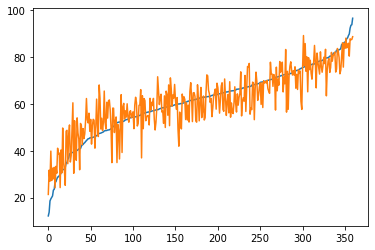

In [19]:
plt.plot(y_to_vis)
plt.plot(v_to_vis)

# Ridge Linear Regression
Let's continue with **L2-regularization**. It works worse

In [28]:
from sklearn.linear_model import Ridge
lr_ridge = Ridge(alpha=0.15, tol = 1e-2)
lr_mae, corr_lr = fit_and_evaluate(lr_ridge)

print('Ridge Regression Performance: MAE test = %0.4f, MAE val = %0.4f' % lr_mae)

SRCC test 0.8381 6.908432330358995e-13
SRCC validation 0.7943 7.397516675371519e-11
Ridge Regression Performance: MAE test = 0.2540, MAE val = 0.2952


# Elastic Net
The combination of L1 and L2 also gives a slightly worse result.

In [55]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

In [56]:
from sklearn import decomposition, datasets
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler


# Create a pca object
pca = decomposition.PCA()

    # Create a logistic regression object with an L2 penalty
elasticnet = linear_model.ElasticNet()

    # Create a pipeline of three steps. 
    # Second, tranform the data with PCA.
    # Third, train a Decision Tree Classifier on the data.
pipe = Pipeline(steps=[('pca', pca), ('elasticnet', elasticnet)])

# Create Parameter Space
# Create a list of a sequence of integers from 1 to 30 (the number of features in X + 1)
n_components = list(range(1,X.shape[1]+1,1))

# Create lists of parameter for ElasticNet Regression
normalize = [True, False]
selection = ['cyclic', 'random']

    # Create a dictionary of all the parameter options 
    # Note has you can access the parameters of steps of a pipeline by using '__’
parameters = dict(pca__n_components=n_components,
                      elasticnet__normalize=normalize,
                      elasticnet__selection=selection)

    # Conduct Parameter Optmization With Pipeline
    # Create a grid search object
clf = GridSearchCV(pipe, parameters)

    # Fit the grid search
clf.fit(X, y)

    # View The Best Parameters
print('Best Number Of Components:', clf.best_estimator_.get_params()['pca__n_components'])
print(); print(clf.best_estimator_.get_params()['elasticnet'])

    # Use Cross Validation To Evaluate Model
CV_Result = cross_val_score(clf, X, y, cv=10, n_jobs=-1, scoring='r2')
print(); print(CV_Result)
print(); print(CV_Result.mean())
print(); print(CV_Result.std())

Best Number Of Components: 1

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=True, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

[-10.0661505  -87.69855987 -56.21993484 -29.87494599  -4.03717268
  -2.9043969  -23.94557228 -51.59263003 -73.8529581  -10.5950977 ]

-35.07874188784762

28.925450108947757


In [57]:
clf.best_estimator_

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=1,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('elasticnet',
                 ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                            l1_ratio=0.5, max_iter=1000, normalize=True,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001,
                            warm_start=False))],
         verbose=False)

In [37]:
lr = ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True,
                            l1_ratio=0.5, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001,
                            warm_start=False)
#lr_mae = fit_and_evaluate(lr, X_train, y_train, X_test, y_test)
lr_mae, corr = fit_and_evaluate(lr)

print('ElasticNet Regression Performance: MAE test = %0.4f, MAE val = %0.4f' % lr_mae)
model_pred = lr.predict(X_test)
model_pred_val = lr.predict(X_val)

print(model_pred)

print(spearmanr(model_pred, y_test))
print(spearmanr(model_pred_val, y_val))

SRCC test 0.7644 9.894714461406362e-10
SRCC validation 0.7295 1.312354371160162e-08
ElasticNet Regression Performance: MAE test = 0.2948, MAE val = 0.3470
[-0.93717946 -0.41478401 -0.81135166 -0.56707678 -0.71770785  0.34415019
  0.03751899 -0.17431031  0.16565602  0.48151333  0.28844085  0.18078206
  0.30468082  0.54940713  0.5506692   0.81687802  0.74476442  0.30618366
  0.54043811  0.28959244  0.60590121  0.52949154  0.49628098  0.62303251
  0.1541372   0.5301694   0.15402857  0.31299855  0.48946605  0.69548183
  0.60373927  0.89228379  0.38916194  0.78448059  0.48088684  0.45577541
  1.20929813  0.54555137  0.64064492  1.16712608  0.76927936  0.90903926
  1.50261714  1.58330984  1.91899639]
SpearmanrResult(correlation=0.7644268774703556, pvalue=9.894714461406362e-10)
SpearmanrResult(correlation=0.7295125164690381, pvalue=1.312354371160162e-08)


# Referense-free Linear Regression 
It is necessary to remove all signs that we accepted as invalid, that did not pass the statistical test and that require knowledge of the reference video

In [38]:
X_with_cols.columns

Index(['initial buffer time', 'Rebuffer count',
       'average duration of stalling event', 'mean(seqPSNR)',
       'averageWeightedBitrate', 'st_events_max', 'bitrate_pos_changes_count',
       'bitrate_neg_changes_count', 'bitrate_max_pos_change',
       'bitrate_max_neg_change', 'bitrate_mean_pos_change',
       'bitrate_mean_neg_change', 'freq_of_st', 'Bitrate switch count',
       'freq_of_sw', 'Rebuffer percentage',
       'Average Bitrate Swithcing magnitude',
       'Average relative Bitrate Swithcing magnitude',
       'Ratio on highest sequense quality layer',
       'Ratio on minimum sequense quality layer',
       'Ratio on sequense quality layer max/2', 'Average Resolution', 'SI',
       'TI', 'content', 'motion', 'Constant_bitrate'],
      dtype='object')

In [77]:
categorical_subset = data_all[['content', 'motion', "Constant_bitrate"]]
#
categorical_subset = categorical_subset.drop (['content', 'motion'], axis = 1)
#

mos = data_all["MOS"]
numerical_subset = data_all.copy()
numerical_subset = numerical_subset.drop (["MOS", 'content', 'motion', "Constant_bitrate"], axis = 1)

#
numerical_subset = numerical_subset.drop (["initial buffer time", 
                                           'mean(seqPSNR)', 'bitrate_pos_changes_count', 
                                           "bitrate_max_pos_change"], axis = 1)
#numerical_subset = numerical_subset.drop (["bitrate_mean_pos_change", 'TI', 'SI', 
                                          # "Ratio on sequense quality layer max/2"], axis = 1)

numerical_subset = numerical_subset.drop (["bitrate_mean_pos_change", 'TI', 'SI'], axis = 1)
   

features = pd.concat([numerical_subset, categorical_subset], axis = 1)
features = pd.concat([features, data_all["MOS"]], axis = 1)

features = pd.concat([numerical_subset, categorical_subset], axis = 1)
targets = pd.DataFrame(data_all["MOS"])


def transmutation(mos):
    return math.log(mos/(100-mos))

for index, row in targets.iterrows():
     value = transmutation(row['MOS'])
     #print (value)
     targets.at[index, 'MOS'] = value
 
index_test =[]
index_val= []
for i in range(45):
    random.seed(42) 
    #print (10*i, 9 + 10*i)
    a = random.randint(10*i, 9 + 10*i)
    index_test.append (a)
    #random.seed(24) 
    while (a != 0):
        b = random.randint(10*i, 9 + 10*i)
        if (a!=b):
            a = 0
            index_val.append (b)

k=10
n = 45#450/k
k_folds = np.zeros((k,n))
#Отсортировать по MOS
sorted_features = pd.concat([features, targets], axis = 1)
sorted_features = sorted_features.sort_values(['MOS'])
sorted_features.set_index(np.arange(450) )

val = sorted_features.iloc [index_val]

targets = pd.DataFrame(sorted_features["MOS"])
sorted_features = sorted_features.drop (["MOS"], axis = 1)


X_ = sorted_features.drop(index_test)
X_ = X_.drop(index_val)
X_test_ = sorted_features.iloc [index_test]
X_val_ = sorted_features.iloc [index_val]

train_labels = targets.drop(index_test)
train_labels = train_labels.drop(index_val)
test_labels = targets.iloc [index_test]
val_labels = targets.iloc [index_val]


columns_save_ = sorted_features.columns

X_with_cols_ = pd.DataFrame(sorted_features, columns = columns_save_)

X = np.array(X_)
X_test = np.array(X_test_)
X_val = np.array(X_val_)

# Sklearn wants the labels as one-dimensional vectors
y = np.array(train_labels).reshape((-1,))
y_test = np.array(test_labels).reshape((-1,))
y_val = np.array(val_labels).reshape((-1, ))

In [87]:
al = 0.0000001
srcc = []
for i in range (10000):
    lr_lasso_red = Lasso(alpha=al + 10*al*i, tol = 2e-1)
    lr_mae, corr_lr = fit_and_evaluate(lr_lasso_red)
    srcc.append (corr_lr)

SRCC test 0.8426 3.9625692844004743e-13
SRCC validation 0.754 2.2355639659541353e-09
SRCC test 0.8426 3.9625692844004743e-13
SRCC validation 0.754 2.2355639659541353e-09
SRCC test 0.8426 3.9625692844004743e-13
SRCC validation 0.754 2.2355639659541353e-09
SRCC test 0.8426 3.9625692844004743e-13
SRCC validation 0.754 2.2355639659541353e-09
SRCC test 0.8426 3.9625692844004743e-13
SRCC validation 0.754 2.2355639659541353e-09
SRCC test 0.8426 3.9625692844004743e-13
SRCC validation 0.7551 2.0622328928647544e-09
SRCC test 0.8426 3.9625692844004743e-13
SRCC validation 0.7551 2.0622328928647544e-09
SRCC test 0.8426 3.9625692844004743e-13
SRCC validation 0.7551 2.0622328928647544e-09
SRCC test 0.8426 3.9625692844004743e-13
SRCC validation 0.7551 2.0622328928647544e-09
SRCC test 0.8426 3.9625692844004743e-13
SRCC validation 0.7551 2.0622328928647544e-09
SRCC test 0.8426 3.9625692844004743e-13
SRCC validation 0.7551 2.0622328928647544e-09
SRCC test 0.8426 3.9625692844004743e-13
SRCC validation 0.7

SRCC test 0.8449 2.931727459728549e-13
SRCC validation 0.7561 1.9015717290617503e-09
SRCC test 0.8449 2.931727459728549e-13
SRCC validation 0.7561 1.9015717290617503e-09
SRCC test 0.8449 2.931727459728549e-13
SRCC validation 0.7561 1.9015717290617503e-09
SRCC test 0.8449 2.931727459728549e-13
SRCC validation 0.7561 1.9015717290617503e-09
SRCC test 0.8449 2.931727459728549e-13
SRCC validation 0.7561 1.9015717290617503e-09
SRCC test 0.8449 2.931727459728549e-13
SRCC validation 0.7561 1.9015717290617503e-09
SRCC test 0.8449 2.931727459728549e-13
SRCC validation 0.7561 1.9015717290617503e-09
SRCC test 0.8449 2.931727459728549e-13
SRCC validation 0.7561 1.9015717290617503e-09
SRCC test 0.8449 2.931727459728549e-13
SRCC validation 0.7561 1.9015717290617503e-09
SRCC test 0.8449 2.931727459728549e-13
SRCC validation 0.7561 1.9015717290617503e-09
SRCC test 0.8449 2.931727459728549e-13
SRCC validation 0.7561 1.9015717290617503e-09
SRCC test 0.8449 2.931727459728549e-13
SRCC validation 0.7561 1.9

SRCC test 0.8456 2.693943551043267e-13
SRCC validation 0.7552 2.041475719137247e-09
SRCC test 0.8456 2.693943551043267e-13
SRCC validation 0.7552 2.041475719137247e-09
SRCC test 0.8456 2.693943551043267e-13
SRCC validation 0.7552 2.041475719137247e-09
SRCC test 0.8456 2.693943551043267e-13
SRCC validation 0.7552 2.041475719137247e-09
SRCC test 0.8456 2.693943551043267e-13
SRCC validation 0.7552 2.041475719137247e-09
SRCC test 0.8456 2.693943551043267e-13
SRCC validation 0.7552 2.041475719137247e-09
SRCC test 0.8456 2.693943551043267e-13
SRCC validation 0.7552 2.041475719137247e-09
SRCC test 0.8456 2.693943551043267e-13
SRCC validation 0.7552 2.041475719137247e-09
SRCC test 0.8456 2.693943551043267e-13
SRCC validation 0.7552 2.041475719137247e-09
SRCC test 0.8456 2.693943551043267e-13
SRCC validation 0.7552 2.041475719137247e-09
SRCC test 0.8456 2.693943551043267e-13
SRCC validation 0.7552 2.041475719137247e-09
SRCC test 0.8456 2.693943551043267e-13
SRCC validation 0.7552 2.041475719137

SRCC test 0.8456 2.693943551043267e-13
SRCC validation 0.7552 2.041475719137247e-09
SRCC test 0.8456 2.693943551043267e-13
SRCC validation 0.7552 2.041475719137247e-09
SRCC test 0.8456 2.693943551043267e-13
SRCC validation 0.7552 2.041475719137247e-09
SRCC test 0.8456 2.693943551043267e-13
SRCC validation 0.7552 2.041475719137247e-09
SRCC test 0.8456 2.693943551043267e-13
SRCC validation 0.7552 2.041475719137247e-09
SRCC test 0.8456 2.693943551043267e-13
SRCC validation 0.7552 2.041475719137247e-09
SRCC test 0.8456 2.693943551043267e-13
SRCC validation 0.7552 2.041475719137247e-09
SRCC test 0.8456 2.693943551043267e-13
SRCC validation 0.7552 2.041475719137247e-09
SRCC test 0.8456 2.693943551043267e-13
SRCC validation 0.7552 2.041475719137247e-09
SRCC test 0.8456 2.693943551043267e-13
SRCC validation 0.7552 2.041475719137247e-09
SRCC test 0.8456 2.693943551043267e-13
SRCC validation 0.7552 2.041475719137247e-09
SRCC test 0.8456 2.693943551043267e-13
SRCC validation 0.7552 2.041475719137

SRCC test 0.8407 4.992003415599741e-13
SRCC validation 0.7539 2.258166711995027e-09
SRCC test 0.8407 4.992003415599741e-13
SRCC validation 0.7539 2.258166711995027e-09
SRCC test 0.8407 4.992003415599741e-13
SRCC validation 0.7539 2.258166711995027e-09
SRCC test 0.8407 4.992003415599741e-13
SRCC validation 0.7539 2.258166711995027e-09
SRCC test 0.8407 4.992003415599741e-13
SRCC validation 0.7539 2.258166711995027e-09
SRCC test 0.8407 4.992003415599741e-13
SRCC validation 0.7539 2.258166711995027e-09
SRCC test 0.8407 4.992003415599741e-13
SRCC validation 0.7539 2.258166711995027e-09
SRCC test 0.8407 4.992003415599741e-13
SRCC validation 0.7539 2.258166711995027e-09
SRCC test 0.8407 4.992003415599741e-13
SRCC validation 0.7539 2.258166711995027e-09
SRCC test 0.8407 4.992003415599741e-13
SRCC validation 0.7539 2.258166711995027e-09
SRCC test 0.8407 4.992003415599741e-13
SRCC validation 0.7539 2.258166711995027e-09
SRCC test 0.8407 4.992003415599741e-13
SRCC validation 0.7539 2.258166711995

SRCC test 0.8366 8.239884968508377e-13
SRCC validation 0.7526 2.496295477199948e-09
SRCC test 0.8366 8.239884968508377e-13
SRCC validation 0.7526 2.496295477199948e-09
SRCC test 0.8366 8.239884968508377e-13
SRCC validation 0.7526 2.496295477199948e-09
SRCC test 0.8366 8.239884968508377e-13
SRCC validation 0.7526 2.496295477199948e-09
SRCC test 0.8366 8.239884968508377e-13
SRCC validation 0.7526 2.496295477199948e-09
SRCC test 0.8366 8.239884968508377e-13
SRCC validation 0.7526 2.496295477199948e-09
SRCC test 0.8366 8.239884968508377e-13
SRCC validation 0.7526 2.496295477199948e-09
SRCC test 0.8366 8.239884968508377e-13
SRCC validation 0.7526 2.496295477199948e-09
SRCC test 0.8366 8.239884968508377e-13
SRCC validation 0.7526 2.496295477199948e-09
SRCC test 0.8366 8.239884968508377e-13
SRCC validation 0.7526 2.496295477199948e-09
SRCC test 0.8366 8.239884968508377e-13
SRCC validation 0.7526 2.496295477199948e-09
SRCC test 0.8366 8.239884968508377e-13
SRCC validation 0.7526 2.496295477199

SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.7526 2.496295477199948e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.7526 2.496295477199948e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.7526 2.496295477199948e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.7526 2.496295477199948e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.7526 2.496295477199948e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.7526 2.496295477199948e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.7526 2.496295477199948e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.7526 2.496295477199948e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.7526 2.496295477199948e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.7526 2.496295477199948e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.7526 2.496295477199948e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.7526 2.496295477199948e-09
SRCC

SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.7565 1.8444112384721275e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.7565 1.8444112384721275e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.7565 1.8444112384721275e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.7565 1.8444112384721275e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.7565 1.8444112384721275e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.7565 1.8444112384721275e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.7565 1.8444112384721275e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.7565 1.8444112384721275e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.7565 1.8444112384721275e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.7565 1.8444112384721275e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.7565 1.8444112384721275e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.7565 1.8444112384721

SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.757 1.7707025465598692e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.757 1.7707025465598692e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.757 1.7707025465598692e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.757 1.7707025465598692e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.757 1.7707025465598692e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.757 1.7707025465598692e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.757 1.7707025465598692e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.757 1.7707025465598692e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.757 1.7707025465598692e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.757 1.7707025465598692e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.757 1.7707025465598692e-09
SRCC test 0.8356 9.35669658934331e-13
SRCC validation 0.757 1.7707025465598692e-09
SRCC

SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7559 1.9405976717524664e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7559 1.9405976717524664e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7559 1.9405976717524664e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7559 1.9405976717524664e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7559 1.9405976717524664e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7559 1.9405976717524664e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7559 1.9405976717524664e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7559 1.9405976717524664e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7559 1.9405976717524664e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7559 1.9405976717524664e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7559 1.9405976717524664e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7559 1.9405976717524

SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7588 1.5497872290335507e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7588 1.5497872290335507e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7588 1.5497872290335507e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7588 1.5497872290335507e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7588 1.5497872290335507e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7588 1.5497872290335507e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7588 1.5497872290335507e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7588 1.5497872290335507e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7588 1.5497872290335507e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7588 1.5497872290335507e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7588 1.5497872290335507e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7588 1.5497872290335

SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7598 1.426988757996902e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7598 1.426988757996902e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7598 1.426988757996902e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7598 1.426988757996902e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7598 1.426988757996902e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7598 1.426988757996902e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7598 1.426988757996902e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7598 1.426988757996902e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7598 1.426988757996902e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7598 1.426988757996902e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7598 1.426988757996902e-09
SRCC test 0.837 7.854527213702721e-13
SRCC validation 0.7598 1.426988757996902e-09
SRCC

SRCC test 0.8349 1.0125745208908525e-12
SRCC validation 0.7598 1.426988757996902e-09
SRCC test 0.8349 1.0125745208908525e-12
SRCC validation 0.7598 1.426988757996902e-09
SRCC test 0.8349 1.0125745208908525e-12
SRCC validation 0.7598 1.426988757996902e-09
SRCC test 0.8349 1.0125745208908525e-12
SRCC validation 0.7598 1.426988757996902e-09
SRCC test 0.8349 1.0125745208908525e-12
SRCC validation 0.7598 1.426988757996902e-09
SRCC test 0.8349 1.0125745208908525e-12
SRCC validation 0.7598 1.426988757996902e-09
SRCC test 0.8349 1.0125745208908525e-12
SRCC validation 0.7598 1.426988757996902e-09
SRCC test 0.8349 1.0125745208908525e-12
SRCC validation 0.7598 1.426988757996902e-09
SRCC test 0.8349 1.0125745208908525e-12
SRCC validation 0.7598 1.426988757996902e-09
SRCC test 0.8349 1.0125745208908525e-12
SRCC validation 0.7598 1.426988757996902e-09
SRCC test 0.8349 1.0125745208908525e-12
SRCC validation 0.7598 1.426988757996902e-09
SRCC test 0.8349 1.0125745208908525e-12
SRCC validation 0.7598 1.

SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7598 1.4315727596076944e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7598 1.4315727596076944e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7598 1.4315727596076944e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7598 1.4315727596076944e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7598 1.4315727596076944e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7598 1.4315727596076944e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7598 1.4315727596076944e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7598 1.4315727596076944e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7598 1.4315727596076944e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7598 1.4315727596076944e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7598 1.4315727596076944e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validatio

SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validatio

SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validatio

SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validatio

SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8295 1.9106582996196287e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8304 1.717069241649429e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8304 1.717069241649429e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8304 1.717069241649429e-12
SRCC validation 0

SRCC test 0.8296 1.8817938871404422e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8296 1.8817938871404422e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8296 1.8817938871404422e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8296 1.8817938871404422e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8296 1.8817938871404422e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8296 1.8817938871404422e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8296 1.8817938871404422e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8296 1.8817938871404422e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8296 1.8817938871404422e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8296 1.8817938871404422e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8296 1.8817938871404422e-12
SRCC validation 0.7621 1.1871106717423064e-09
SRCC test 0.8296 1.8817938871404422e-12
SRCC validatio

SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validatio

SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validatio

SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7624 1.1625124313531662e-09
SRCC test 0.8307 1.6652562591906531e-12
SRCC validatio

SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.

SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.

SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.719163931856383e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7646 9.

SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7648 9.616736614017742e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7648 9.616736614017742e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7648 9.616736614017742e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7648 9.616736614017742e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7648 9.616736614017742e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7648 9.616736614017742e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7648 9.616736614017742e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7648 9.616736614017742e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7648 9.616736614017742e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7648 9.616736614017742e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7648 9.616736614017742e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7648 9.

SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7648 9.616736614017742e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7648 9.616736614017742e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7648 9.616736614017742e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7648 9.616736614017742e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7648 9.616736614017742e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7648 9.616736614017742e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7648 9.616736614017742e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7648 9.616736614017742e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7648 9.616736614017742e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7648 9.616736614017742e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7648 9.616736614017742e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7648 9.

SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7665 8.

SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8307 1.6652562591906531e-12
SRCC validation 0.7665 8.

SRCC test 0.8273 2.470115732097032e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8273 2.470115732097032e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8273 2.470115732097032e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8273 2.470115732097032e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8273 2.470115732097032e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8273 2.470115732097032e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8273 2.470115732097032e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8273 2.470115732097032e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8273 2.470115732097032e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8273 2.470115732097032e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8273 2.470115732097032e-12
SRCC validation 0.7665 8.374149649941906e-10
SRCC test 0.8273 2.470115732097032e-12
SRCC validation 0.7665 8.374149649941

SRCC test 0.8287 2.0928168636891543e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.8287 2.0928168636891543e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.8287 2.0928168636891543e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.8287 2.0928168636891543e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.8287 2.0928168636891543e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.8287 2.0928168636891543e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.8287 2.0928168636891543e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.8287 2.0928168636891543e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.8287 2.0928168636891543e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.8287 2.0928168636891543e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.8287 2.0928168636891543e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.8287 2.0928168636891543e-12
SRCC validation 0.7672 7.

SRCC test 0.8287 2.0928168636891543e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.8287 2.0928168636891543e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.8287 2.0928168636891543e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.8287 2.0928168636891543e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.8287 2.0928168636891543e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.8287 2.0928168636891543e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.8287 2.0928168636891543e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.8287 2.0928168636891543e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.8287 2.0928168636891543e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.8287 2.0928168636891543e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.8287 2.0928168636891543e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.93

SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC

SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC

SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC

SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7672 7.937707351278754e-10
SRCC

SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7691 6.753078467813486e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7691 6.753078467813486e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7691 6.753078467813486e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7691 6.753078467813486e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7691 6.753078467813486e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7691 6.753078467813486e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7691 6.753078467813486e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7691 6.753078467813486e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7691 6.753078467813486e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7691 6.753078467813486e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7691 6.753078467813486e-10
SRCC test 0.83 1.7976509044073738e-12
SRCC validation 0.7691 6.753078467813486e-10
SRCC

SRCC test 0.8292 1.9696457810210555e-12
SRCC validation 0.7687 6.975824845069391e-10
SRCC test 0.8292 1.9696457810210555e-12
SRCC validation 0.7687 6.975824845069391e-10
SRCC test 0.8292 1.9696457810210555e-12
SRCC validation 0.7687 6.975824845069391e-10
SRCC test 0.8292 1.9696457810210555e-12
SRCC validation 0.7687 6.975824845069391e-10
SRCC test 0.8292 1.9696457810210555e-12
SRCC validation 0.7687 6.975824845069391e-10
SRCC test 0.8292 1.9696457810210555e-12
SRCC validation 0.7687 6.975824845069391e-10
SRCC test 0.8292 1.9696457810210555e-12
SRCC validation 0.7687 6.975824845069391e-10
SRCC test 0.8292 1.9696457810210555e-12
SRCC validation 0.7687 6.975824845069391e-10
SRCC test 0.8292 1.9696457810210555e-12
SRCC validation 0.7687 6.975824845069391e-10
SRCC test 0.8292 1.9696457810210555e-12
SRCC validation 0.7687 6.975824845069391e-10
SRCC test 0.8292 1.9696457810210555e-12
SRCC validation 0.7687 6.975824845069391e-10
SRCC test 0.8292 1.9696457810210555e-12
SRCC validation 0.7687 6.

SRCC test 0.8281 2.257017677309751e-12
SRCC validation 0.7687 6.975824845069391e-10
SRCC test 0.8281 2.257017677309751e-12
SRCC validation 0.7687 6.975824845069391e-10
SRCC test 0.8281 2.257017677309751e-12
SRCC validation 0.7687 6.975824845069391e-10
SRCC test 0.8281 2.257017677309751e-12
SRCC validation 0.7687 6.975824845069391e-10
SRCC test 0.8281 2.257017677309751e-12
SRCC validation 0.7687 6.975824845069391e-10
SRCC test 0.8281 2.257017677309751e-12
SRCC validation 0.7687 6.975824845069391e-10
SRCC test 0.8281 2.257017677309751e-12
SRCC validation 0.7687 6.975824845069391e-10
SRCC test 0.8281 2.257017677309751e-12
SRCC validation 0.7687 6.975824845069391e-10
SRCC test 0.8281 2.257017677309751e-12
SRCC validation 0.7687 6.975824845069391e-10
SRCC test 0.8281 2.257017677309751e-12
SRCC validation 0.7687 6.975824845069391e-10
SRCC test 0.8281 2.257017677309751e-12
SRCC validation 0.7687 6.975824845069391e-10
SRCC test 0.8281 2.257017677309751e-12
SRCC validation 0.7687 6.975824845069

SRCC test 0.8281 2.257017677309751e-12
SRCC validation 0.7654 9.119628716834078e-10
SRCC test 0.8281 2.257017677309751e-12
SRCC validation 0.7654 9.119628716834078e-10
SRCC test 0.8281 2.257017677309751e-12
SRCC validation 0.7654 9.119628716834078e-10
SRCC test 0.8281 2.257017677309751e-12
SRCC validation 0.7654 9.119628716834078e-10
SRCC test 0.8281 2.257017677309751e-12
SRCC validation 0.7654 9.119628716834078e-10
SRCC test 0.8281 2.257017677309751e-12
SRCC validation 0.7654 9.119628716834078e-10
SRCC test 0.8281 2.257017677309751e-12
SRCC validation 0.7654 9.119628716834078e-10
SRCC test 0.8281 2.257017677309751e-12
SRCC validation 0.7654 9.119628716834078e-10
SRCC test 0.8281 2.257017677309751e-12
SRCC validation 0.7654 9.119628716834078e-10
SRCC test 0.8281 2.257017677309751e-12
SRCC validation 0.7654 9.119628716834078e-10
SRCC test 0.8281 2.257017677309751e-12
SRCC validation 0.7654 9.119628716834078e-10
SRCC test 0.8281 2.257017677309751e-12
SRCC validation 0.7654 9.119628716834

SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7654 9.119628716834078e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7654 9.119628716834078e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7654 9.119628716834078e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7654 9.119628716834078e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7654 9.119628716834078e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7654 9.119628716834078e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7654 9.119628716834078e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7654 9.119628716834078e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7654 9.119628716834078e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7654 9.119628716834078e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7654 9.119628716834078e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7654 9.

SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7644 9.

SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8277 2.3612983729513696e-12
SRCC validation 0.7644 9.

SRCC test 0.8249 3.2291589454567385e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8249 3.2291589454567385e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8249 3.2291589454567385e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8249 3.2291589454567385e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8249 3.2291589454567385e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8249 3.2291589454567385e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8249 3.2291589454567385e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8249 3.2291589454567385e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8249 3.2291589454567385e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8249 3.2291589454567385e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8249 3.2291589454567385e-12
SRCC validation 0.7644 9.927099572146155e-10
SRCC test 0.8249 3.2291589454567385e-12
SRCC validation 0.7644 9.

SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7611 1.2904750174604995e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7611 1.2904750174604995e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7611 1.2904750174604995e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7611 1.2904750174604995e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7611 1.2904750174604995e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7611 1.2904750174604995e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7611 1.2904750174604995e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7611 1.2904750174604995e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7611 1.2904750174604995e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7611 1.2904750174604995e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7611 1.2904750174604995e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validatio

SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validatio

SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8252 3.1350556907679904e-12
SRCC validatio

SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4

SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4

SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4919661310127012e-09
SRCC test 0.8244 3.425420545210475e-12
SRCC validation 0.7592 1.4

SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7595 1.4

SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validatio

SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validatio

SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validatio

SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validatio

SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7595 1.4614766605255643e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validatio

SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7618 1.2249259093135933e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7618 1.2249259093135933e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7618 1.2249259093135933e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7618 1.2249259093135933e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7618 1.2249259093135933e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7618 1.2249259093135933e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7618 1.2249259093135933e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7618 1.2249259093135933e-09
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0

SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7649 9.515323645309022e-10
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7649 9.515323645309022e-10
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7649 9.515323645309022e-10
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7649 9.515323645309022e-10
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7649 9.515323645309022e-10
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7645 9.

SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8215 4.7222358993906804e-12
SRCC validation 0.7645 9.

SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7645 9.822615067647657e-10
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7645 9.822615067647

SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7643 1.0

SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8232 3.908949069665302e-12
SRCC validation 0.7643 1.0

SRCC test 0.8224 4.2663385556115696e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8224 4.2663385556115696e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8224 4.2663385556115696e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8224 4.2663385556115696e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8224 4.2663385556115696e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8224 4.2663385556115696e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8224 4.2663385556115696e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8224 4.2663385556115696e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8224 4.2663385556115696e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8224 4.2663385556115696e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8224 4.2663385556115696e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8224 4.2663385556115696e-12
SRCC validatio

SRCC test 0.8202 5.453831972576806e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8202 5.453831972576806e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8202 5.453831972576806e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8202 5.453831972576806e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8202 5.453831972576806e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8202 5.453831972576806e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8202 5.453831972576806e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8202 5.453831972576806e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8202 5.453831972576806e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8202 5.453831972576806e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8202 5.453831972576806e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8202 5.453831972576806e-12
SRCC validation 0.7643 1.0

SRCC test 0.8195 5.85853347583431e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8195 5.85853347583431e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8195 5.85853347583431e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8195 5.85853347583431e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8195 5.85853347583431e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8195 5.85853347583431e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8195 5.85853347583431e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8195 5.85853347583431e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8195 5.85853347583431e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8195 5.85853347583431e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8195 5.85853347583431e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8195 5.85853347583431e-12
SRCC validation 0.7643 1.0032627078689

SRCC test 0.8195 5.85853347583431e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8195 5.85853347583431e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8195 5.85853347583431e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8195 5.85853347583431e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8195 5.85853347583431e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8195 5.85853347583431e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8195 5.85853347583431e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8195 5.85853347583431e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8195 5.85853347583431e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8195 5.85853347583431e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8195 5.85853347583431e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8195 5.85853347583431e-12
SRCC validation 0.7643 1.0032627078689

SRCC test 0.8174 7.352411776796967e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8174 7.352411776796967e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8174 7.352411776796967e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8174 7.352411776796967e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8174 7.352411776796967e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8174 7.352411776796967e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8174 7.352411776796967e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8174 7.352411776796967e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8174 7.352411776796967e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8174 7.352411776796967e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8174 7.352411776796967e-12
SRCC validation 0.7643 1.0032627078689838e-09
SRCC test 0.8174 7.352411776796967e-12
SRCC validation 0.7643 1.0

0.8455862977602107
191


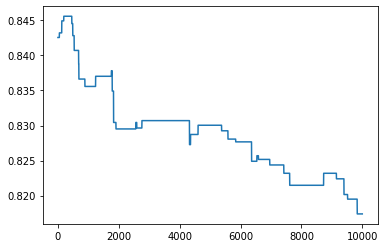

In [88]:
plt.plot(srcc, label="SRCC")
print(max(srcc))
print(np.argmax(srcc))

In [95]:
lr_lasso_red = Lasso(alpha=al + 10*al*np.argmax(srcc), tol = 2e-1)
lr_mae, corr_lr = fit_and_evaluate(lr_lasso_red)

print('Lasso Regression Performance: MAE test = %0.4f, MAE val = %0.4f' % lr_mae)

SRCC test 0.8456 2.693943551043267e-13
SRCC validation 0.7561 1.9015717290617503e-09
Lasso Regression Performance: MAE test = 0.2721, MAE val = 0.3511


This model turned out to be less accurate **(0.70 SRCC)**.
However, if you leave the sign of reproduction at the quality level, more than half of the maximum, the accuracy of the model increases significantly **(0.76 SRCC on validation)**

More extensive research is required to decide which features can be considered universal across all services.

In [96]:
Lasso_lin_reg = np.dot(X_val, lr_lasso.coef_) + lr_lasso.intercept_

In [100]:
Referense_free = np.dot(np.array(X_val_), lr_lasso_red.coef_) + lr_lasso_red.intercept_

In [98]:
Lin_reg_simple_to_vis= list (map(lambda x : vqa(x), Lin_reg_simple))

NameError: name 'Lin_reg_simple' is not defined

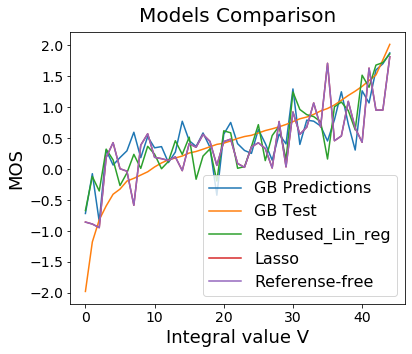

In [103]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(1, 1, 1)
plt.plot(model_pred_val, label = "GB Predictions")
plt.plot(y_test, label = "GB Test")

plt.plot(Redused_lin_reg, label = "Redused_Lin_reg")

plt.plot(Lasso_lin_reg, label = "Lasso")
plt.plot(Referense_free, label = "Referense-free")
plt.legend(fontsize=16)

ax.set_xlabel("Integral value V", fontsize=18)
ax.set_ylabel("MOS", fontsize=18)

ax.set_title("Models Comparison", fontsize=20, verticalalignment='bottom')

ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

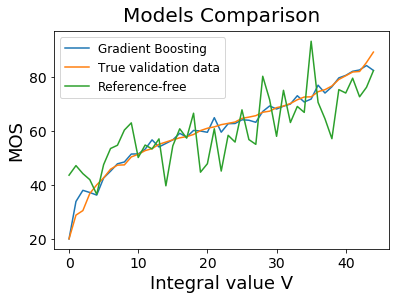

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.style.use('grayscale')

plt.plot(model_pred_val, label = "Gradient Boosting")
plt.plot(y_val, label = "True validation data")


plt.plot(Redused_lin_reg, label = "Reference-free")


ax.set_title("Models Comparison", fontsize=20, verticalalignment='bottom')

plt.legend(fontsize=12)
ax.set_xlabel("Integral value V", fontsize=18)
ax.set_ylabel("MOS", fontsize=18)

ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

## Locally Interpretable Model-agnostic Explanations

We will look at using [LIME to explain individual predictions](https://github.com/marcotcr/lime) made the by the model. LIME is a relatively new effort aimed at showing how a machine learning model thinks by approximating the region around a prediction with a linear model.

We will look at trying to explain the predictions on an example the model gets very wrong and an example the model gets correct. We will restrict ourselves to using the reduced set of 10 features to aid interpretability. The model trained on the 10 most important features is slightly less accurate, but we generally have to trade off accuracy for interpretability!


### REMEMBER
We applied the transmutation of MOS values

This piece of code can be commented out and our MOS values will be from 0 to 100

In [105]:
# Create the model with the same hyperparamters
model_reduced = final_model

# Fit and test on the reduced set of features
model_reduced.fit(X_reduced, y)
model_reduced_pred = model_reduced.predict(X_test_reduced)
model_reduced_pred_val = model_reduced.predict(X_val_reduced)

/home/ksant/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


In [106]:
# Find the residuals
residuals = abs(model_reduced_pred - y_test)
    
# Exact the worst and best prediction
wrong = X_test_reduced[np.argmax(residuals), :]
right = X_test_reduced[np.argmin(residuals), :]

In [107]:
# LIME for explaining predictions
import lime 
import lime.lime_tabular

In [108]:
# Create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_reduced, 
                                                   mode = 'regression',
                                                   training_labels = y,
                                                   feature_names = list(most_important_features))

Prediction: 0.5873
Actual Value: -0.0984


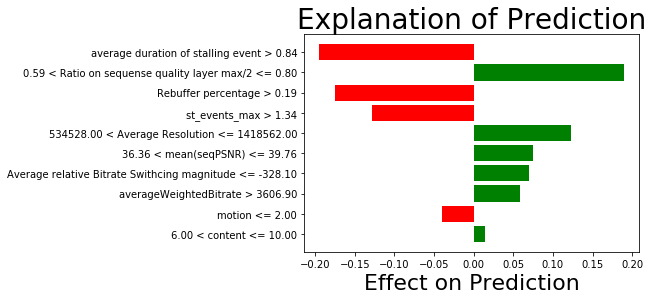

In [110]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(wrong.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmax(residuals)])

# Explanation for wrong prediction
wrong_exp = explainer.explain_instance(data_row = wrong, 
                                       predict_fn = model_reduced.predict)

# Plot the prediction explaination
wrong_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [111]:
wrong_exp.show_in_notebook(show_predicted_value=False)

Prediction: 0.5435
Actual Value: 0.5439


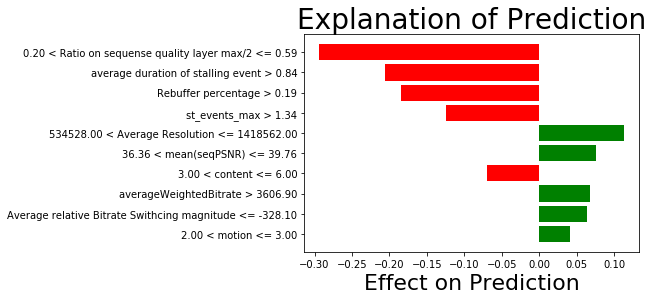

In [112]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(right.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmin(residuals)])

# Explanation for wrong prediction
right_exp = explainer.explain_instance(right, model_reduced.predict, num_features=10)
right_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

# Examining a Single Decision Tree

One of the coolest parts about a tree-based ensemble is that we can look at any individual estimator. Although our final model is composed of 800 decision trees, and looking at a single one is not indicative of the entire model, it still allows us to see the general idea of how a decision tree works. From there, it is a natural extension to imagine hundreds of these trees [building off the mistakes of previous trees](https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d) to make a final prediction (this is a significant oversimplification of how [gradient boosting regression works!](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html))

We will first extract a tree from the forest and then save it using `sklearn.tree.export_graphviz`. This saves the tree as a `.dot` file which can be converted to a png using command line instructions in the Notebook.

In [114]:
# Extract a single tree
from sklearn import tree
#single_tree = model_reduced.estimators_[105][0]

single_tree = model_reduced.estimators_[70][0]


tree.export_graphviz(single_tree, out_file = 'tree.dot',
                     rounded = True, 
                     feature_names = most_important_features,
                     filled = True)

single_tree

DecisionTreeRegressor(ccp_alpha=0.0, criterion='friedman_mse', max_depth=7,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=11,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=RandomState(MT19937) at 0x7FE0A7189380,
                      splitter='best')

In [115]:
!dot -Tpng tree.dot -o tree.png

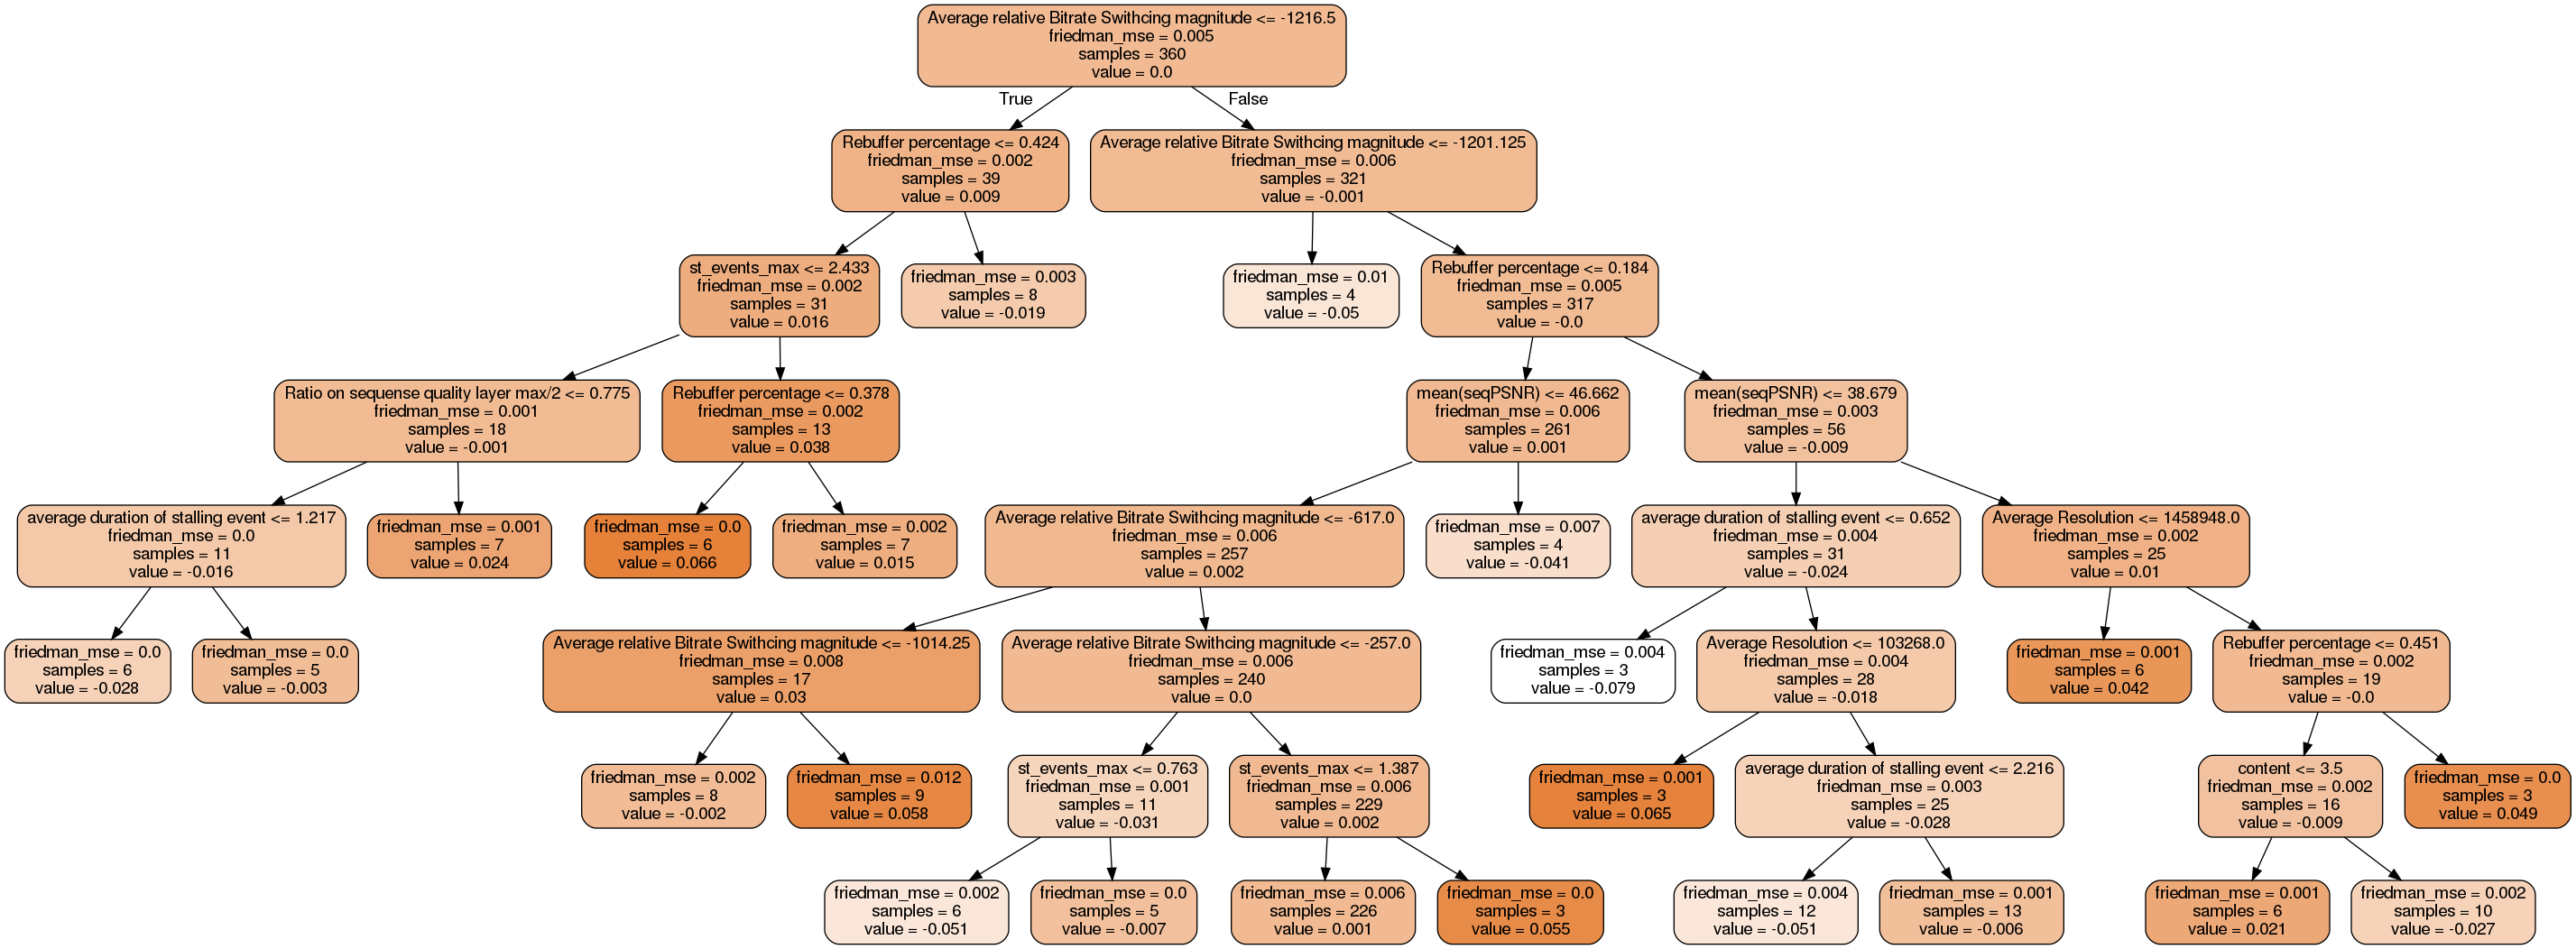

In [119]:
from IPython.display import Image
Image(filename='tree.png')

That's one entire tree in our regressor of 80! It's a little difficult to make out because the maximum depth of the tree is 5. To improve the readability, we can limit the max depth in the call to export our tree.

In [120]:
tree.export_graphviz(single_tree, out_file = 'tree_small.dot',
                     rounded = True, feature_names = most_important_features,
                     filled = True, max_depth = 3)

In [121]:
!dot -Tpng tree_small.dot -o tree_small.png

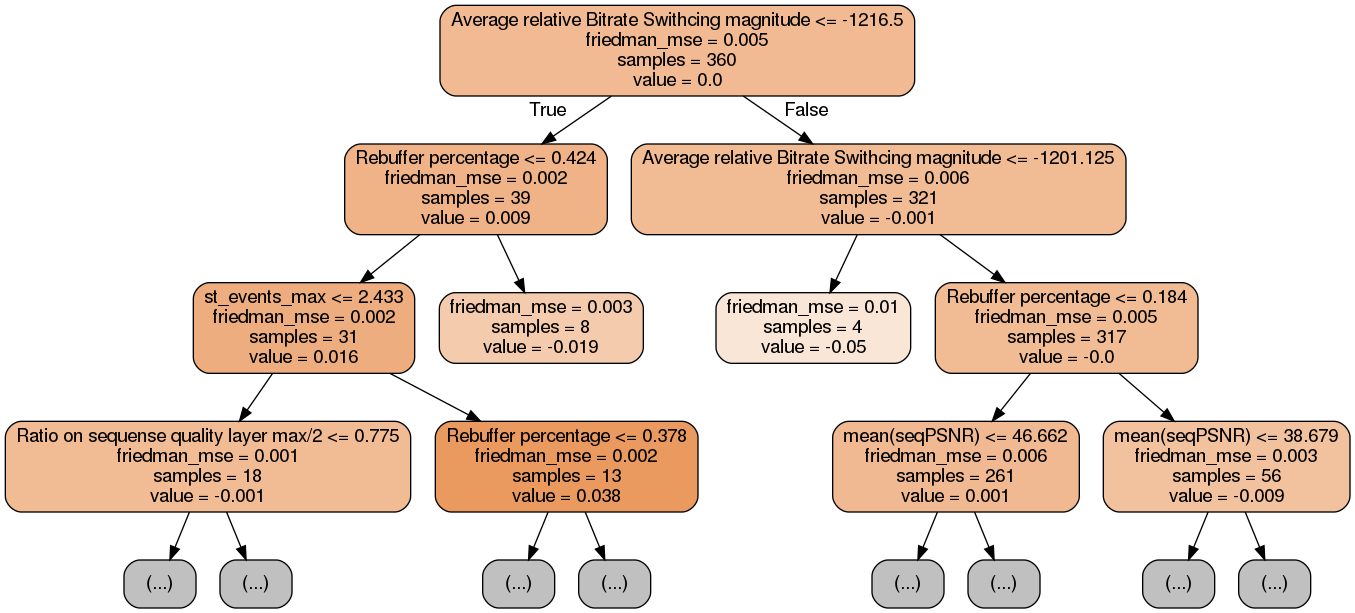

In [122]:
from IPython.display import Image
Image(filename='tree_small.png')

# Each node has four different pieces of information:

1. The question: based on this answer we move right or left to the next node a layer down in the tree
2. The friedman_mse: a measure of the error for all of the examples in a given node
3. The samples: number of examples in a node
4. The value: the prediction of the target for all examples in a node

We can see that as we increase the depth of the tree, we will be better able to fit the data. With a small tree, there will be many examples in each leaf node, and because the model estimates the same value for each example in a node, there will probably be a larger error (unless all of the examples have the same target value). Constructing too large of a tree though can lead to overfitting. We can control a number of hyperparameters that determine the depth of the tree and the number of examples in each leaf. We saw how to select a few of these hyperaparameters in the second part when we performed optimimation using cross validation. 

Although we clearly cannot examine every tree in our model, looking at a single one does give us some idea how our model makes predictions. In fact, this flowchart based method seems much like how a human makes decisions, answering one question about a single value at a time. Decision tree based ensembles simply take the idea of a single decision tree and combine the predictions of many individuals in order to create a model with less variance than a single estimator. Ensembles of trees tend to be very accurate, and also are intuitive to explain! 

# Summary 

We've come a long way in studying the Waterloo dataset and building a quality assessment model.

Some of the machine learning models presented at the end of the work can be trained more accurately by completely iterating over all their hyperparameters.

In addition, the question remains as to which features are correct to leave in the referenceless model.

I hope you can improve my results, but for now I will focus on developing correct ways to estimate motion and content type, and try to explore the effects of memory.

If you have any questions - write to me by mail ivchenko.a.v@phystech.edu